# OCR 비교 실험

In [1]:
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import easyocr
import pandas as pd
from paddleocr import PaddleOCR

# TEST 이미지 
image_path = "./data/easy_task_test05_v1.PNG"

# 시각화용
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"   # local 폰트 설정
font = ImageFont.truetype(font_path, 15)                        # 폰트 사이즈 조정

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tesseract OCR

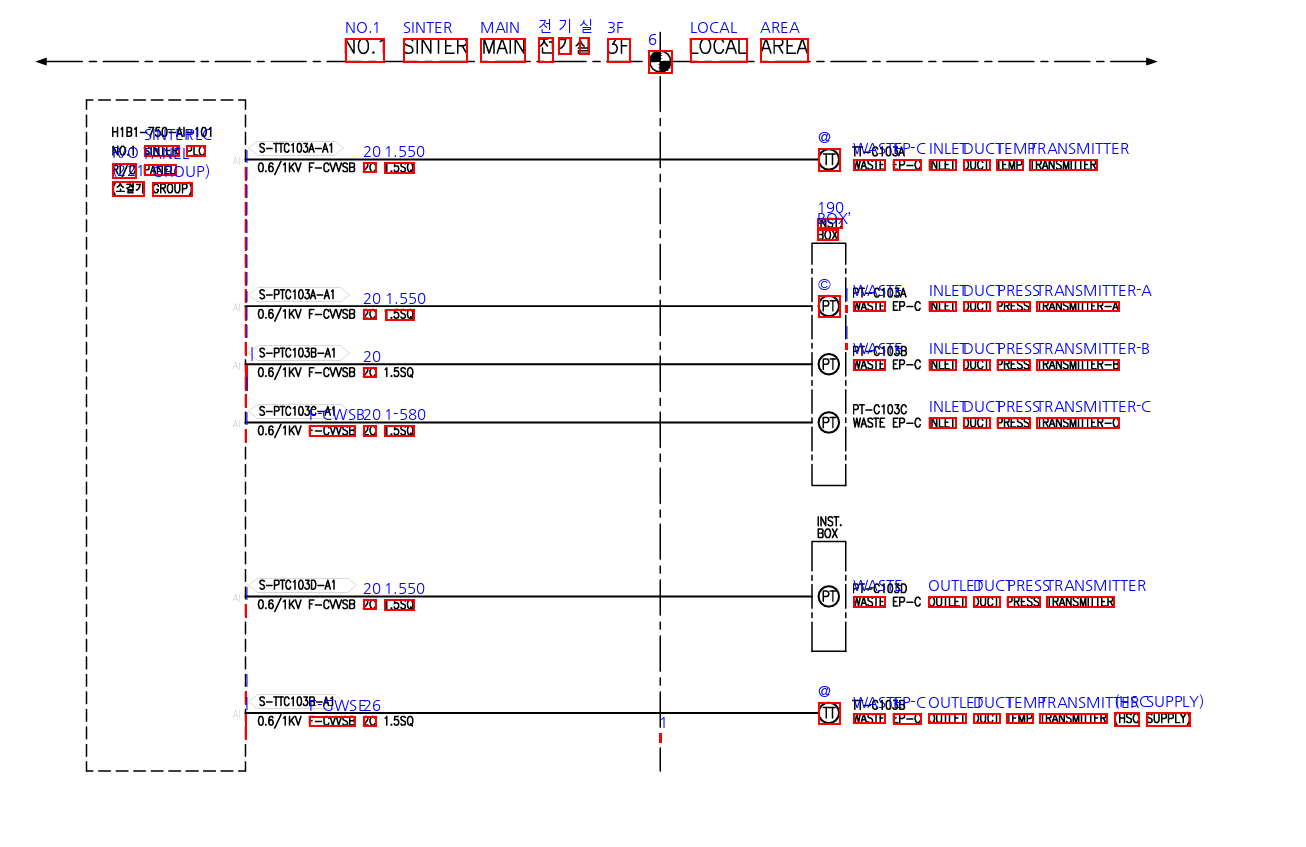

In [2]:
image_tess = Image.open(image_path).convert("RGB")

# OCR 결과 (박스 정보,좌표 포함)
tess_data = pytesseract.image_to_data(image_tess, lang='eng+kor', output_type=pytesseract.Output.DICT)
draw_tess = ImageDraw.Draw(image_tess)
tess_texts = []

for i in range(len(tess_data['text'])):
    text = tess_data['text'][i]
    conf = int(tess_data['conf'][i])
    
    # confidence가 너무 낮거나 공백이면 스킵
    if conf > 50 and text.strip() != "":
        x, y, w, h = tess_data['left'][i], tess_data['top'][i], tess_data['width'][i], tess_data['height'][i]
        draw_tess.rectangle([(x, y), (x + w, y + h)], outline="red", width=2)       # 텍스트 영역 red 박스로 표시
        draw_tess.text((x, y - 20), text, fill="blue", font=font)                   # 텍스트는 blue로 표시
        tess_texts.append({"text": text, "confidence": conf, "bbox": (x, y, w, h)})

df_tess = pd.DataFrame(tess_texts)

image_tess.show()

# # 텍스트 로그 확인
# print("\n🟥 Tesseract OCR 결과:")
# print(df_tess[['text','confidence']])

## EasyOCR OCR

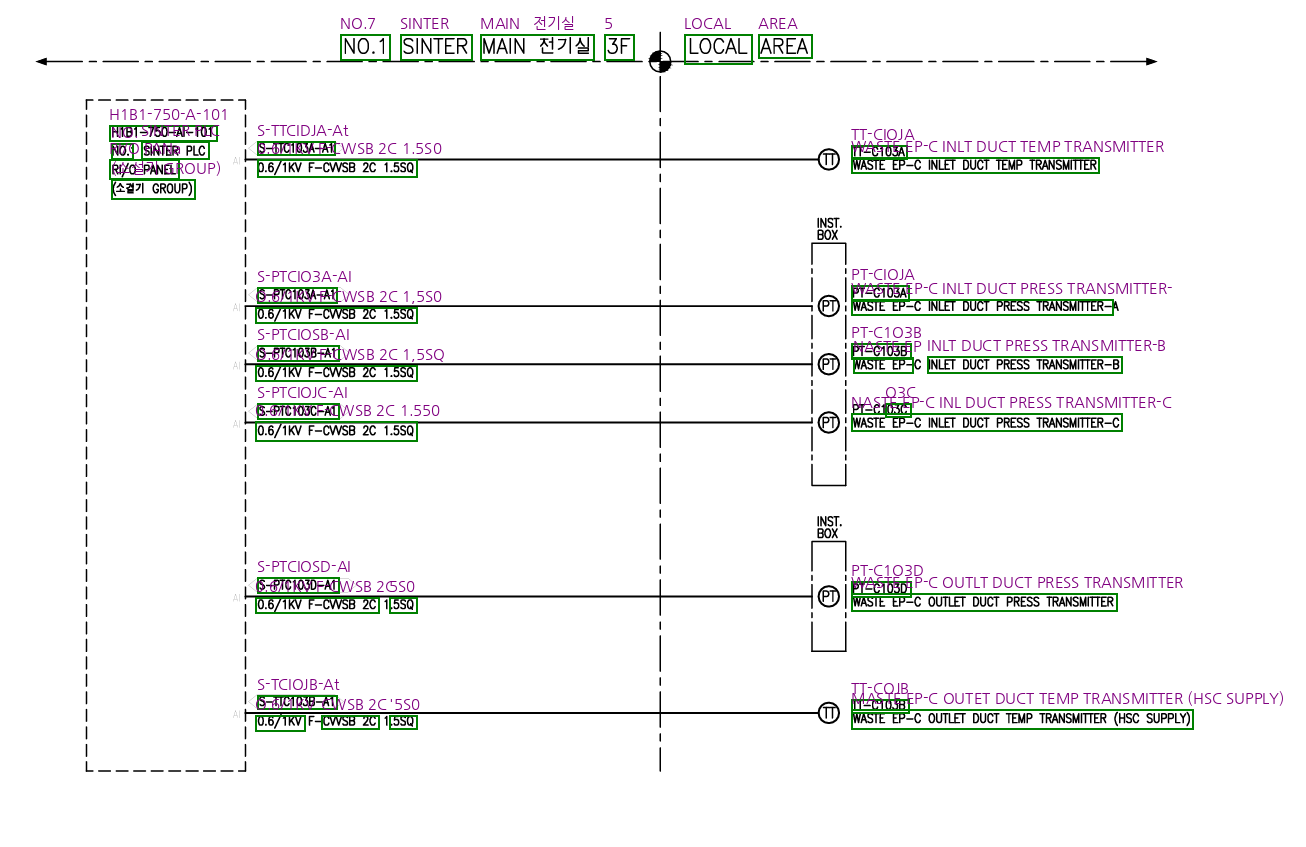

In [3]:
image_easy = Image.open(image_path).convert("RGB")
reader = easyocr.Reader(['en','ko'])
results_easy = reader.readtext(image_path)
draw_easy = ImageDraw.Draw(image_easy)
easy_texts = []

for bbox, text, prob in results_easy:
    x_min = min([p[0] for p in bbox])
    y_min = min([p[1] for p in bbox])
    x_max = max([p[0] for p in bbox])
    y_max = max([p[1] for p in bbox])
    
    draw_easy.rectangle([x_min, y_min, x_max, y_max], outline="green", width=2)
    draw_easy.text((x_min, y_min - 20), text, fill="purple", font=font)
    easy_texts.append({"text": text, "confidence": prob, "bbox": (x_min, y_min, x_max-x_min, y_max-y_min)})

df_easy = pd.DataFrame(easy_texts)
image_easy.show()

# # 텍스트 로그 확인
# print("\n🟩 EasyOCR 결과:")
# print(df_easy[['text','confidence']])

## PaddleOCR

/tmp/ipykernel_938249/2146309931.py:4: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_paddle = PaddleOCR(use_angle_cls=True, lang='korean')
/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/UVDoc`.
Creati

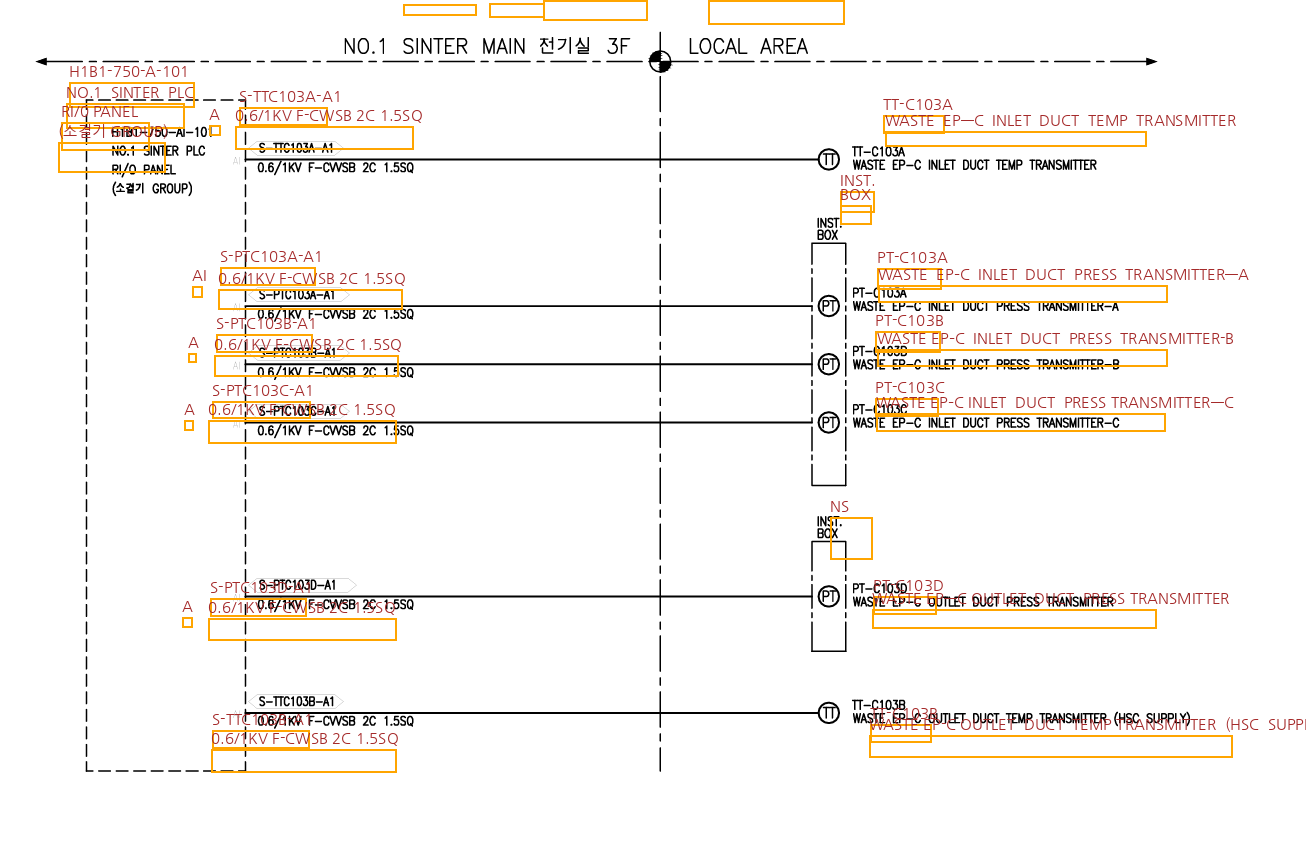

In [4]:
image_paddle = Image.open(image_path).convert("RGB")
draw_paddle = ImageDraw.Draw(image_paddle)

ocr_paddle = PaddleOCR(use_angle_cls=True, lang='korean')
results_paddle = ocr_paddle.ocr(image_path)

res = results_paddle[0]
boxes = res.get('rec_boxes', [])    
texts = res.get('rec_texts', [])
scores = res.get('rec_scores', [])

paddle_texts = []

for box, text, score in zip(boxes, texts, scores):
    if text.strip() == "":
        continue  # 빈 텍스트 무시
    # rec_boxes는 [x_min, y_min, x_max, y_max] 형태
    x_min, y_min, x_max, y_max = map(int, box)

    draw_paddle.rectangle([x_min, y_min, x_max, y_max], outline="orange", width=2)
    draw_paddle.text((x_min, y_min - 20), text, fill="brown", font=font)

    paddle_texts.append({
        "text": text,
        "confidence": score,
        "bbox": (x_min, y_min, x_max-x_min, y_max-y_min)
    })

df_paddle = pd.DataFrame(paddle_texts)
image_paddle.show()

# print("\n🟧 PaddleOCR 결과:")
# print(df_paddle[['text','confidence']])

In [5]:
""" results_paddle keys :
input_path
page_index
doc_preprocessor_res
dt_polys
model_settings
text_det_params
text_type
text_rec_score_thresh
return_word_box
rec_texts
rec_scores
rec_polys
vis_fonts
textline_orientation_angles
rec_boxes
"""

' results_paddle keys :\ninput_path\npage_index\ndoc_preprocessor_res\ndt_polys\nmodel_settings\ntext_det_params\ntext_type\ntext_rec_score_thresh\nreturn_word_box\nrec_texts\nrec_scores\nrec_polys\nvis_fonts\ntextline_orientation_angles\nrec_boxes\n'

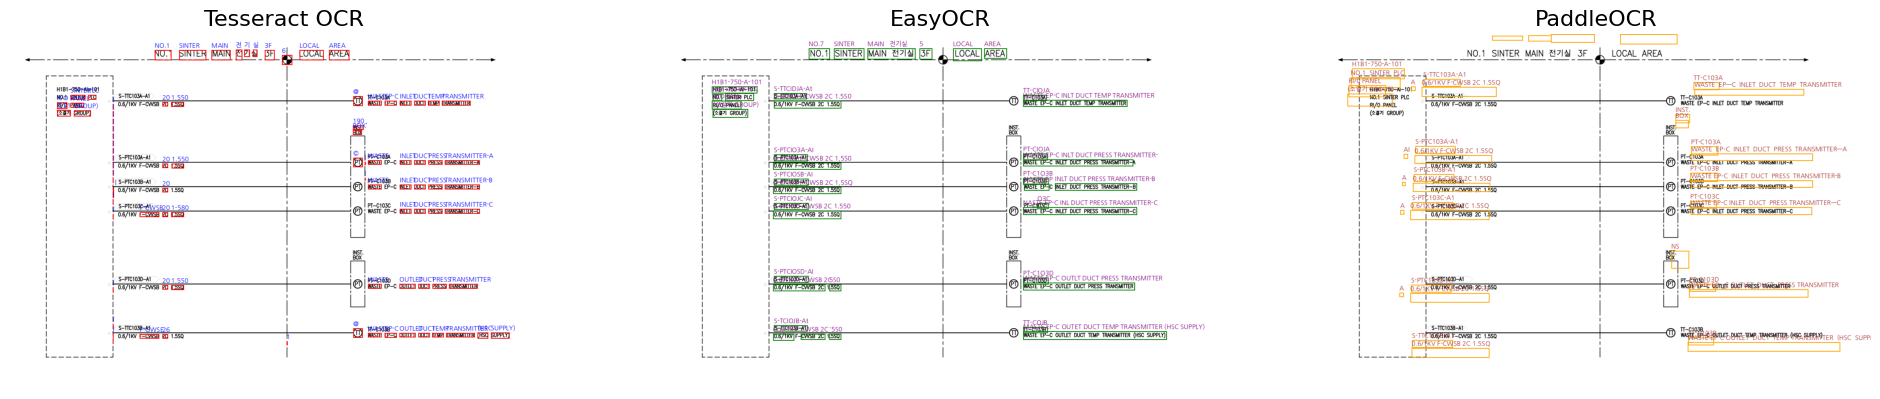

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_tess)
plt.title("Tesseract OCR", fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_easy)
plt.title("EasyOCR", fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_paddle)
plt.title("PaddleOCR", fontsize=16)
plt.axis('off')

plt.show()

In [ ]:
import pandas as pd

# 각 OCR에서 필요한 컬럼만 선택
df_t = df_tess[['text','confidence']].copy()
df_e = df_easy[['text','confidence']].copy()
df_p = df_paddle[['text','confidence']].copy()

# 컬럼 이름 변경해서 구분
df_t.columns = ['Tesseract_text', 'Tesseract_conf']
df_e.columns = ['EasyOCR_text', 'EasyOCR_conf']
df_p.columns = ['PaddleOCR_text', 'PaddleOCR_conf']

# 길이가 다를 수 있으므로 index 맞춰서 concat
df_combined = pd.concat([df_t, df_e, df_p], axis=1)

# 출력
# print(df_combined)

# 컬러 스타일 지정
def highlight_cols(s):
    color_map = {
        'Tesseract_text': 'lightcoral',
        'EasyOCR_text': 'lightgreen',
        'PaddleOCR_text': 'orange'
    }
    return ['background-color: {}'.format(color_map.get(col, '')) for col in s.index]

# 스타일 적용
df_combined.style.apply(highlight_cols, axis=1)


,Tesseract_text,Tesseract_conf,EasyOCR_text,EasyOCR_conf,PaddleOCR_text,PaddleOCR_conf
0,NO.1,90,NO.7,0.855903,SINIER,0.954986
1,SINTER,96,SINTER,0.998556,MAIN,0.994191
2,MAIN,95,MAIN 전기실,0.957628,전기실 3F,0.914567
3,전,92,5,0.276068,LOCAL AREA,0.970346
4,기,91,LOCAL,0.829089,H1B1-750-A-101,0.994995
5,실,92,AREA,0.999791,NO.1 SINTER PLC,0.936329
6,3F,85,H1B1-750-A-101,0.561940,S-TTC103A-A1,0.984351
7,LOCAL,65,NO.,0.723199,RI/0 PANEL,0.907812
8,AREA,65,SINTER PLC,0.966133,TT-C103A,0.990158
9,SINTER,95,S-TTCIDJA-At,0.536729,A,0.962175
